In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import mnist_pria_awgn

In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [3]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [4]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
"""
#載入加入noise的mnist資料集
noise = 10
(x_train, y_train), (x_test, y_test) = mnist_pria_awgn.build_mnist_awgn(noise)
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)
"""

'\n#載入加入noise的mnist資料集\nnoise = 10\n(x_train, y_train), (x_test, y_test) = mnist_pria_awgn.build_mnist_awgn(noise)\nx_train = x_train.reshape(len(x_train), 28, 28, 1)\nx_test = x_test.reshape(len(x_test), 28, 28, 1)\n'

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
# Normalize and reshape the data
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [14]:
# Create a copy of the data with added noise
noisy_x_train = noise(x_train)
noisy_x_test = noise(x_test)

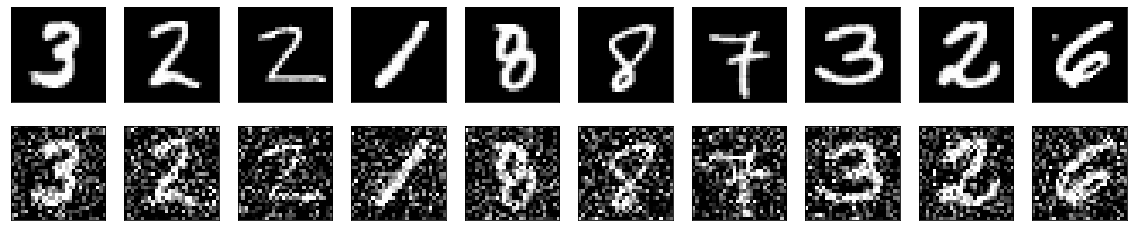

In [10]:
# Display the train data and a version of it with added noise
display(x_train, noisy_x_train)

In [ ]:
"""
#印出加入noise的圖
mnist_pria_awgn.showimgs(x_train[:40], 4, 10)
"""

In [ ]:
#x_train = x_train / 255.0
#x_test = x_test / 255.0

In [11]:
#定義autoencoder
from tensorflow.keras import layers
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.MaxPool2D(pool_size=(2,2))
        ])
        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [18]:
#編譯autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
#train
model = autoencoder.fit(x=noisy_x_train, y=x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(noisy_x_test, x_test))

Epoch 1/10
469/469 [==============================] - 11s 22ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 4/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 [==============================] - 11s 24ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 7/10
469/469 [==============================] - 11s 24ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 8/10
469/469 [==============================] - 11s 24ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 9/10
469/469 [==============================] - 11s 24ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 10/10
469/469 [==============================] - 11s 24ms/step - loss: 0.111

In [ ]:
autoencoder.summary()

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
#mnist_pria_awgn.showimgs(encoded_imgs[:40], 4, 10)

In [ ]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
mnist_pria_awgn.showimgs(decoded_imgs[:40], 4, 10)

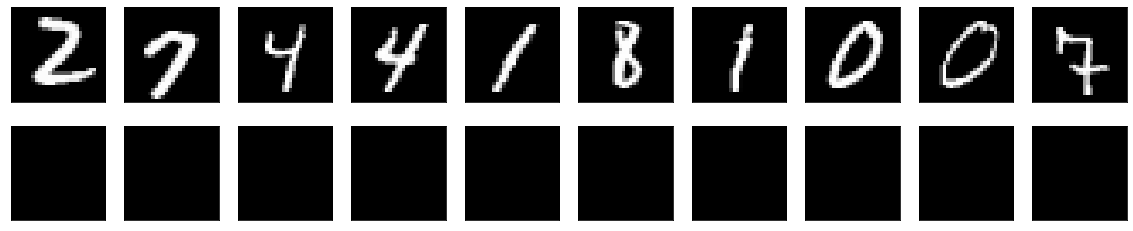

In [17]:
predictions = autoencoder.predict(noisy_x_test)
display(noisy_x_test, predictions)